Fitting 3 folds for each of 243 candidates, totalling 729 fits


c:\Users\natra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
243 fits failed out of a total of 729.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
67 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\natra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\natra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\natra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.

Best parameters found: {'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
R² Score (Test Set): 0.9982
RMSE (Test Set): 0.2193
MAE (Test Set): 0.1538
Predictions saved to 'random_forest_predictions_finetuned.csv'


c:\Users\natra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


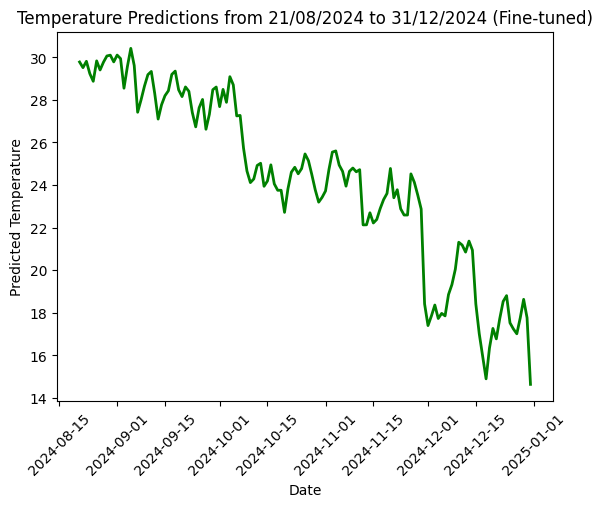

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Load the dataset
file_path = '../../dataset/data.csv'  # Adjust the path to your dataset
data = pd.read_csv(file_path)

# Prepare the data for Random Forest Regression
X = data[['feelslike', 'tempmax', 'tempmin', 'feelslikemax', 'feelslikemin', 'dew', 'sealevelpressure', 'humidity']]
y = data['temp']

# Include the 'datetime' in the dataset
data['datetime'] = pd.to_datetime(data['datetime'], format='%m/%d/%Y')
data['day_of_year'] = data['datetime'].dt.dayofyear

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 1: Fine-tuning the Random Forest model using GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Initialize the Random Forest model
rf = RandomForestRegressor(random_state=42)

# Perform Grid Search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='r2')
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters found:", best_params)

# Step 2: Use the best model to predict on the test set
best_model = grid_search.best_estimator_
y_pred_test = best_model.predict(X_test)

# Step 3: Calculate R², RMSE, and MAE for the test set
r2 = r2_score(y_test, y_pred_test)
rmse = mean_squared_error(y_test, y_pred_test, squared=False)
mae = mean_absolute_error(y_test, y_pred_test)

# Display the performance metrics
print(f"R² Score (Test Set): {r2:.4f}")
print(f"RMSE (Test Set): {rmse:.4f}")
print(f"MAE (Test Set): {mae:.4f}")

# Step 4: Generate a date range from 21/08/2024 to 31/12/2024
future_dates = pd.date_range(start='2024-08-21', end='2024-12-31')
future_day_of_year = future_dates.dayofyear

# Step 5: Use historical averages for each day of the year to simulate future features
# Group the historical data by 'day_of_year' and calculate the average for each feature
historical_averages = data.groupby('day_of_year')[['feelslike', 'tempmax', 'tempmin', 'feelslikemax', 'feelslikemin', 'dew', 'sealevelpressure', 'humidity']].mean()

# Create future features by using historical averages for the corresponding day of the year
future_features = pd.DataFrame({
    'feelslike': [historical_averages.loc[day, 'feelslike'] for day in future_day_of_year],
    'tempmax': [historical_averages.loc[day, 'tempmax'] for day in future_day_of_year],
    'tempmin': [historical_averages.loc[day, 'tempmin'] for day in future_day_of_year],
    'feelslikemax': [historical_averages.loc[day, 'feelslikemax'] for day in future_day_of_year],
    'feelslikemin': [historical_averages.loc[day, 'feelslikemin'] for day in future_day_of_year],
    'dew': [historical_averages.loc[day, 'dew'] for day in future_day_of_year],
    'sealevelpressure': [historical_averages.loc[day, 'sealevelpressure'] for day in future_day_of_year],
    'humidity': [historical_averages.loc[day, 'humidity'] for day in future_day_of_year],
})

# Step 6: Predict the temperature for the future date range using the best model
temp_predictions = best_model.predict(future_features)

# Step 7: Create a DataFrame to store the predictions
future_predictions_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted Temperature': temp_predictions
})

# Step 8: Save the predicted values to a CSV file
future_predictions_df.to_csv('random_forest_predictions_finetuned.csv', index=False)
print("Predictions saved to 'random_forest_predictions_finetuned.csv'")

# Step 9: Plot the predicted temperatures
plt.plot(future_dates, temp_predictions, label='Predicted Temperature', color='green', linewidth=2)
plt.xlabel('Date')
plt.ylabel('Predicted Temperature')
plt.title('Temperature Predictions from 21/08/2024 to 31/12/2024 (Fine-tuned)')
plt.xticks(rotation=45)
plt.show()
